In [1]:
import torch
from mirtorch.prox import prox
from mirtorch.linear import *
from mirtorch.alg import *
from mirtorch.alg.fista import FISTA
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import matplotlib

In [2]:
#Binary classification on MNIST digits using FISTA (specifically 3 and 5)
#get dataset
try:
    X,y = X_orig, y_orig
except:
    X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

y = y.astype(np.float64)
X_orig, y_orig = X, y
print(len(X))
print(len(X[y==3]))
print(len(X[y==5]))
print(len(X[(y==3) | (y==5)]))

def show_digit(X, y):
    digit_image = X.reshape(28,28)
    print(f'Expected digit {y+4}')
    plt.imshow(digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
    plt.axis("off")
    plt.show()

70000
7141
6313
13454


(13454, 784) (13454,)
Expected digit 5.0


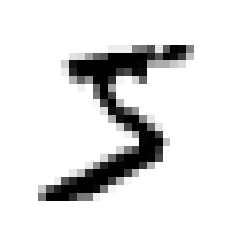

In [3]:
#reduce data to be binary classification for simplicity
X, y = X[(y==3) | (y==5)], y[(y==3) | (y==5)]
y = y - 4
print(X.shape, y.shape)
show_digit(X[0], y[0])
#create train/test sets
X = normalize(X, axis=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=10000, test_size=3454)
X_train, X_test, y_train, y_test = torch.from_numpy(X_train), torch.from_numpy(X_test), torch.from_numpy(y_train), torch.from_numpy(y_test)

In [6]:
X_train = X_train.type(torch.double)
X_test = X_test.type(torch.double)
y_train = y_train.type(torch.double)
y_test = y_test.type(torch.double)

def diff_huberhinge_grad(x, deltah = .1):
    result = torch.where(x>=1, torch.tensor([0],dtype=torch.double), 
                         torch.where(x<=1-deltah, torch.tensor([-1],dtype=torch.double), (x-1)/deltah))
    return result

class A(LinearMap):
    def __init__(self, apply_y = True):
        self._A = X_train.clone()
        if apply_y:
            for i in range(self._A.shape[0]):
                self._A[i] *= y_train[i]
        
        super().__init__([28*28], [10000])
        
    def _apply(self, x):
        return torch.matmul(self._A, x)
    
    def _apply_adjoint(self, x):
        return torch.matmul(self._A.T, x)
        
class grad:
    def __init__(self, dh=.1):
        self.a = A()
        self.deltah = dh
        
    def __call__(self, x):
        x = self.a(x)
        x = diff_huberhinge_grad(x)
        x = self.a.adjoint(x)
        return x
    
def eval(x):
    res = torch.matmul(X_test, x)
    res = torch.sign(res)
    res *= y_test
    total = res.shape[0]
    correct = res[res>0].shape[0]
    print(f'\tCorrect {correct} out of {total} total, percentage: {correct/total}')
    return correct, total

	Correct 3296 out of 3454 total, percentage: 0.9542559351476549


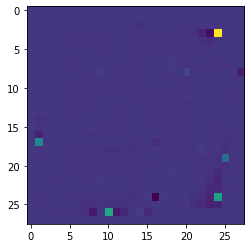

In [14]:
x = torch.zeros(28*28, dtype=torch.double, requires_grad=True)
grad_ = grad()
L = 1/grad_.deltah * torch.linalg.norm(grad_.a._A, float('inf')) * torch.linalg.norm(grad_.a._A, 1)
prox_ = prox.L1Regularizer(.0001)
res = FISTA(max_iter=300, fgrad=grad_, Lf=L, prox=prox_).run_alg(x)
eval(res)
res.sum().backward() #can run .backward() on this
#look at grad of result with respect to starting input
plt.imshow(x.grad.data.reshape(28,28).numpy())

In [15]:
a_mat = A(apply_y=False)
x = torch.zeros(28*28, dtype=torch.double, requires_grad=True)
res = CG(A=a_mat.H*a_mat, max_iter=300).run(x0=x, b=a_mat.H(y_train))

residual at 1th iter: 130151.10287963005
residual at 2th iter: 7761.52935015468
residual at 3th iter: 2452.6380651158106
residual at 4th iter: 963.8992040061985
residual at 5th iter: 393.1200153970831
residual at 6th iter: 316.6854813521478
residual at 7th iter: 148.59014930867937
residual at 8th iter: 91.72921030685653
residual at 9th iter: 63.018407054198725
residual at 10th iter: 49.15001098141681
residual at 11th iter: 35.952865057856755
residual at 12th iter: 21.81566399968476
residual at 13th iter: 268.29231579336613
residual at 14th iter: 20.069491360269588
residual at 15th iter: 13.588715858625568
residual at 16th iter: 11.739099067654713
residual at 17th iter: 8.21867508417376
residual at 18th iter: 10.422624026210514
residual at 19th iter: 8.457904707629643
residual at 20th iter: 6.587085891943401
residual at 21th iter: 5.921871168658417
residual at 22th iter: 5.715179842368026
residual at 23th iter: 38.30267280033651
residual at 24th iter: 27.55632439425942
residual at 25th 

In [16]:
eval(res)


	Correct 3290 out of 3454 total, percentage: 0.952518818760857


(3290, 3454)